In [20]:
import numpy as np
import glob
import random
import os
import imageio.v2 as imageio
import PIL, cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
DATA_DIR = "/kaggle/input/socofing/SOCOFing/Real/"
list_dirs = glob.glob(DATA_DIR + "*.BMP")
num_images = len(list_dirs)
print("Images Imported: ",num_images)

Images Imported:  6000


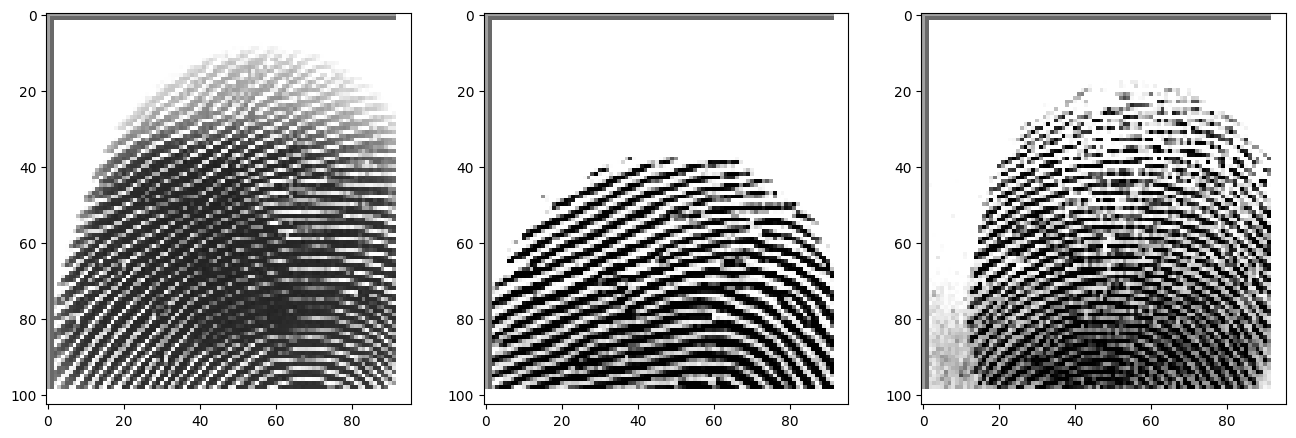

In [3]:
random.seed(42)

r = random.randint(0,num_images)
display_list = list_dirs[r:r+3]

image1 = imageio.imread(display_list[0])
image2 = imageio.imread(display_list[1])
image3 = imageio.imread(display_list[2])

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1);
axes[1].imshow(image2);
axes[2].imshow(image3);

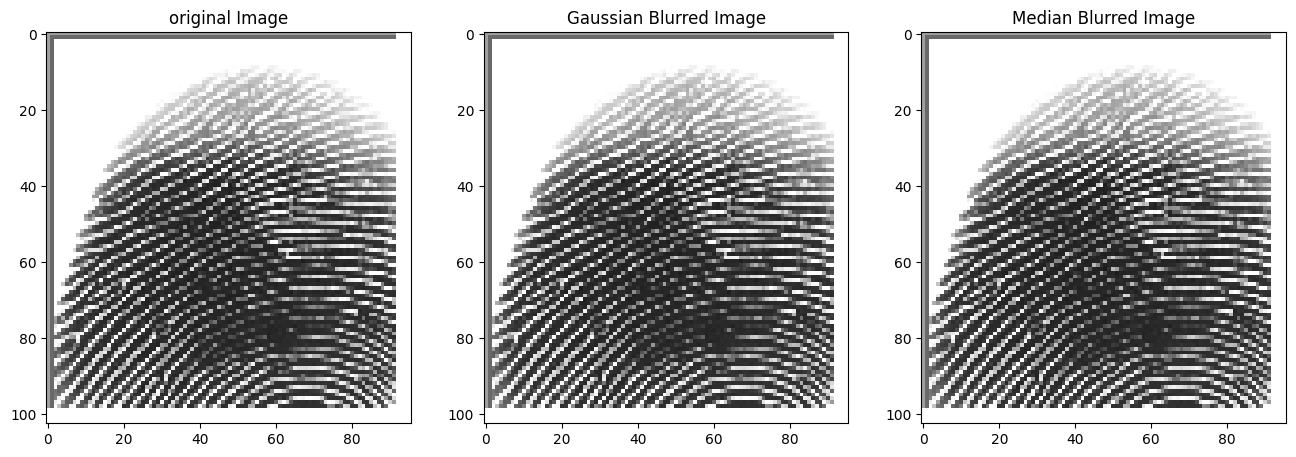

In [4]:
gauss_blur = cv2.GaussianBlur(image1,(1,1),0)
median_blur = cv2.medianBlur(image1,1)

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].set_title("original Image");
axes[0].imshow(image1);
axes[1].set_title("Gaussian Blurred Image");
axes[1].imshow(gauss_blur);
axes[2].set_title("Median Blurred Image");
axes[2].imshow(median_blur);

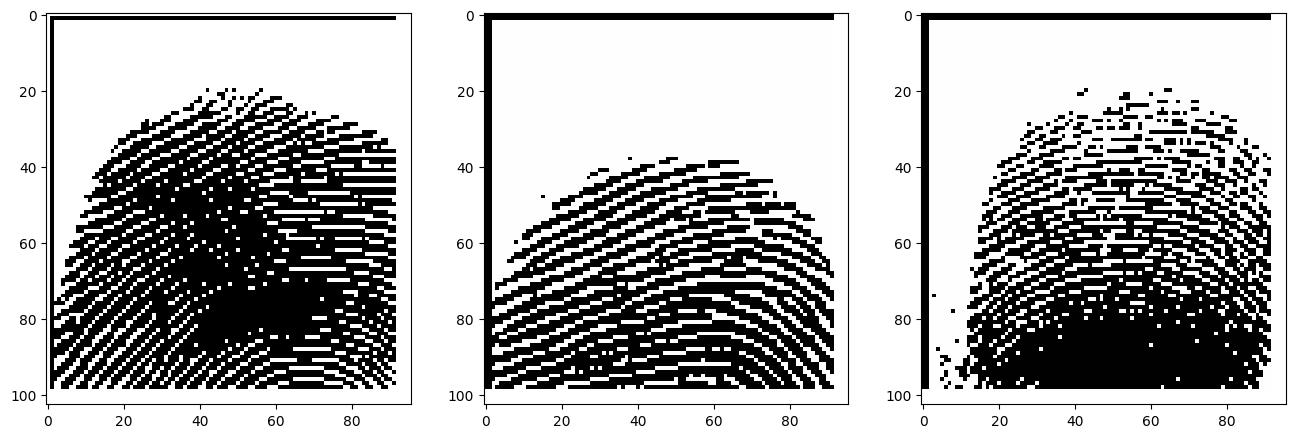

In [5]:
THRESHOLD1 = image1.mean()
THRESHOLD2 = image2.mean()
THRESHOLD3 = image3.mean()

image1 = np.array(image1 > THRESHOLD1).astype(int) * 255
image2 = np.array(image2 > THRESHOLD2).astype(int) * 254
image3 = np.array(image3 > THRESHOLD3).astype(int) * 254

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1);
axes[1].imshow(image2);
axes[2].imshow(image3);

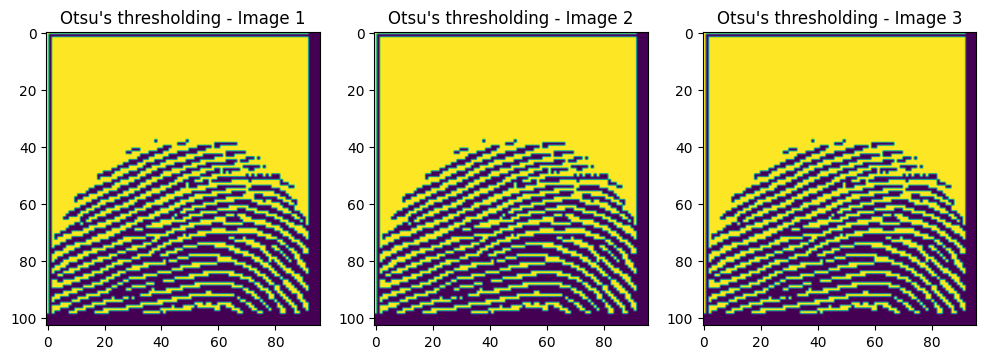

In [6]:
img1 = cv2.imread(display_list[0],0)
img2 = cv2.imread(display_list[1],0)
img3 = cv2.imread(display_list[2],0)

# Otsu's thresholding
ret1,th1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,th2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,th3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(1,3,figsize = (12,12));
axes[0].set_title("Otsu's thresholding - Image 1");
axes[0].imshow(th2);
axes[1].set_title("Otsu's thresholding - Image 2");
axes[1].imshow(th2);
axes[2].set_title("Otsu's thresholding - Image 3");
axes[2].imshow(th2);

In [7]:
img_name = display_list[0]
gray_img_array = np.array(Image.open(img_name).convert('P'))

In [8]:
vertical_robert_filter = np.array([[1,0],[0,-1]])
horizontal_robert_filter = np.array([[0,1],[-1,0]])

vertical_sobel_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
horizontal_sobel_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

vertical_prewitt_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
horizontal_prewitt_filter = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

print("vertical robert filter\n",vertical_robert_filter )
print("horizontal robert filter\n",horizontal_robert_filter)
print("vertical sobel filter: \n", vertical_sobel_filter)
print("horizontal sobel filter: \n", horizontal_sobel_filter)

print("vertical prewitt filter: \n", vertical_prewitt_filter)
print("horizontal prewitt filter: \n", horizontal_prewitt_filter)

vertical robert filter
 [[ 1  0]
 [ 0 -1]]
horizontal robert filter
 [[ 0  1]
 [-1  0]]
vertical sobel filter: 
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
horizontal sobel filter: 
 [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
vertical prewitt filter: 
 [[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
horizontal prewitt filter: 
 [[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


In [9]:
gray_img = Image.fromarray(gray_img_array)

convolved_img1 = convolve(gray_img,vertical_robert_filter)
convolved_img1 = convolve(convolved_img1,horizontal_robert_filter)

convolved_img2 = convolve(gray_img,vertical_sobel_filter)
convolved_img2 = convolve(convolved_img2,horizontal_sobel_filter)

convolved_img3 =  convolve(gray_img,vertical_prewitt_filter )
convolved_img3 =  convolve(gray_img,horizontal_prewitt_filter )

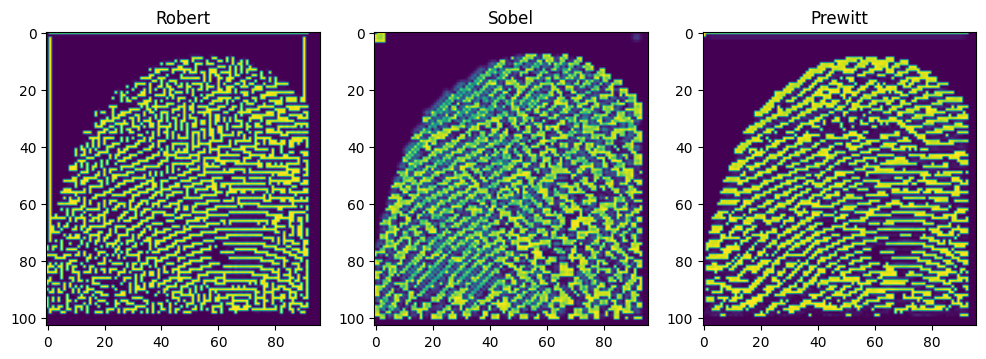

In [10]:
fig, axes = plt.subplots(1,3,figsize = (12,12));
axes[0].set_title("Robert");
axes[0].imshow(convolved_img1);
axes[1].set_title("Sobel");
axes[1].imshow(convolved_img2);
axes[2].set_title("Prewitt");
axes[2].imshow(convolved_img3);

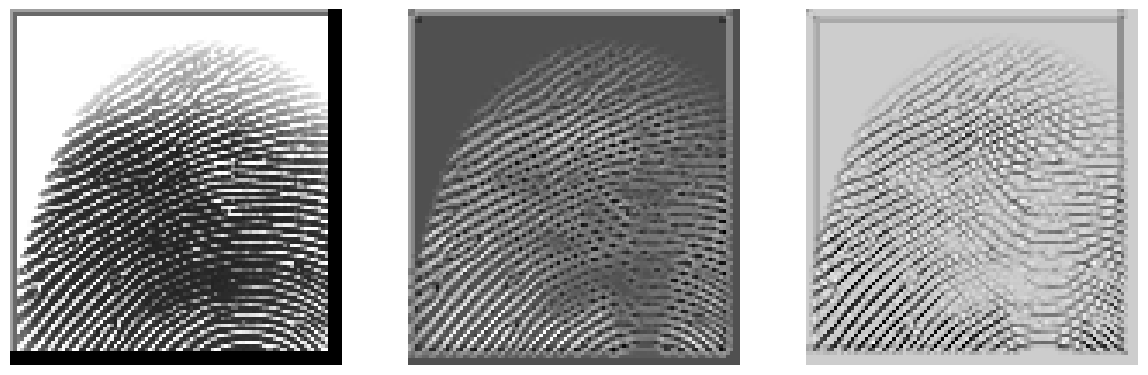

In [11]:
src_path = img_name

def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc', use_gaussian_derivatives=False)
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (12,12))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

img = cv2.imread(src_path, 0) # 0 imports a grayscale
if img is None:
    raise(ValueError(f"Image didn\'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img, sigma=0.15)

plot_images(img, a, b)

In [12]:
def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;
    
    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))         
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [13]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block);
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
            return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)
def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1 
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));
        
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

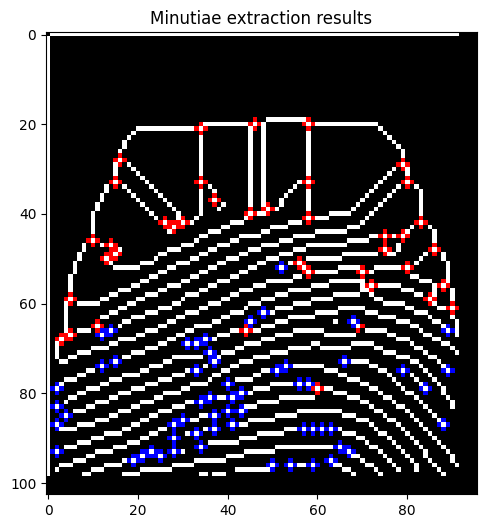

In [14]:
img_name = display_list[1]
img = cv2.imread(img_name,0);
img = np.array(img > THRESHOLD1).astype(int)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255;
mask = img*255;

(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask);
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=1);
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1);
ShowResults(skel, TermLabel, BifLabel)

In [15]:
img_size = 96

def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 
        else: base  = 5 
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
             fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

In [16]:
Altered_path = "/kaggle/input/socofing/SOCOFing/Altered/Altered-"
Real_path = "/kaggle/input/socofing/SOCOFing/Real"

Easy_data = load_data(Altered_path+'Easy', train=True)
# Medium_data = load_data(Altered_path+'Medium', train=True)
# Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)

Altered_data = Easy_data

Loading data from:  /kaggle/input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from:  /kaggle/input/socofing/SOCOFing/Real


In [21]:
X_Altered, y_SubjectID_Altered, y_fingerNum_Altered = [], [], []

for SubjectID, fingerNum, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600) # 600 persons in total
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10) # 10 fingers per person

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

In [22]:
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers, optimizers
nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))
    
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "SubjectID_Mod"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 92, 92, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 600)            │       154,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,935,512 (11.20 MB)

 Trainable params: 2,935,064 (11.20 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "FingerNum_Mod"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 92, 92, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,783,882 (10.62 MB)

 Trainable params: 2,783,434 (10.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
del X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val

In [28]:
from tensorflow.keras import callbacks
nets=2
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train, y_SubjectID_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/20
  3/225 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0000e+00 - loss: 7.9098  

I0000 00:00:1711281694.484238      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711281694.506549      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0021 - loss: 6.7062

W0000 00:00:1711281705.731877      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711281707.218083      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.0021 - loss: 6.7056 - val_accuracy: 5.5757e-04 - val_loss: 8.9178 - learning_rate: 1.0000e-04
Epoch 2/20
  7/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0069 - loss: 6.4571

W0000 00:00:1711281708.665286      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0059 - loss: 6.4470 - val_accuracy: 0.0014 - val_loss: 7.8884 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0154 - loss: 6.2154 - val_accuracy: 0.0190 - val_loss: 6.0782 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0429 - loss: 5.7537 - val_accuracy: 0.0728 - val_loss: 5.4676 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1104 - loss: 5.0130 - val_accuracy: 0.1678 - val_loss: 4.7973 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2334 - loss: 4.0532 - val_accuracy: 0.3242 - val_loss: 3.9121 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4075 - loss: 2.9421 - val_accuracy: 0.5528 - val_loss: 2.8907 - learning_rate: 1.0000e-04
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.58

In [29]:
del X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val

X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

del X_Altered, y_fingerNum_Altered

history[1] = model[1].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/20
  5/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1330 - loss: 4.6683

W0000 00:00:1711281812.445525      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2839 - loss: 2.5102

W0000 00:00:1711281822.436213      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711281823.811934      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.2842 - loss: 2.5082 - val_accuracy: 0.1296 - val_loss: 6.1424 - learning_rate: 1.0000e-04
Epoch 2/20
  7/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5270 - loss: 1.6480

W0000 00:00:1711281824.807664      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4881 - loss: 1.5805 - val_accuracy: 0.3206 - val_loss: 2.5051 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5767 - loss: 1.2983 - val_accuracy: 0.6203 - val_loss: 1.2000 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6375 - loss: 1.1173 - val_accuracy: 0.6953 - val_loss: 1.0066 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7062 - loss: 0.9523 - val_accuracy: 0.7700 - val_loss: 0.8075 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7637 - loss: 0.7796 - val_accuracy: 0.8015 - val_loss: 0.7150 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8175 - loss: 0.6382 - val_accuracy: 0.8341 - val_loss: 0.6356 - learning_rate: 1.0000e-04
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.85

W0000 00:00:1711281921.591052      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Id recognition accuracy:  99.04999732971191 %


W0000 00:00:1711281925.567219      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Finger recognition accuracy:  99.36666488647461 %


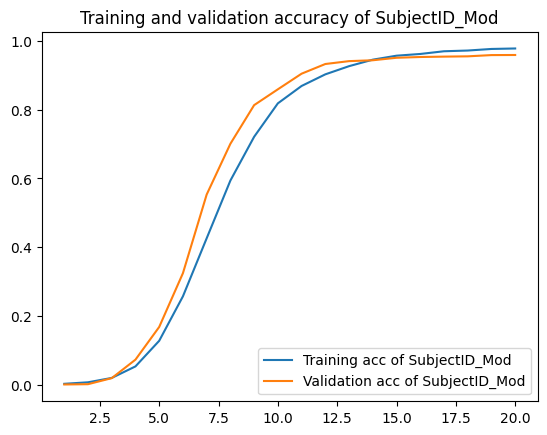

<Figure size 640x480 with 0 Axes>

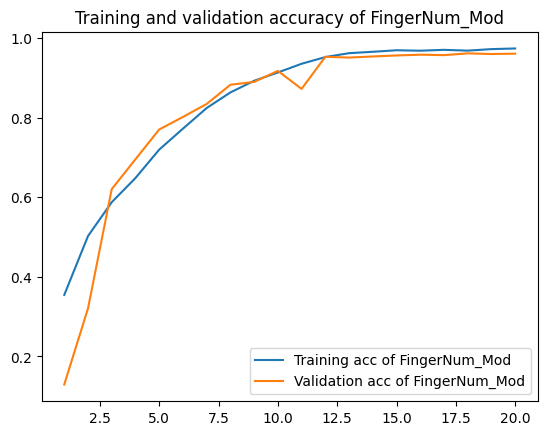

<Figure size 640x480 with 0 Axes>

In [30]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")